In [1]:
import torch
print(torch.cuda.is_available())
print("CUDA available:", torch.cuda.is_available())
print("GPU name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU")

True
CUDA available: True
GPU name: NVIDIA GeForce RTX 3050 Laptop GPU


In [2]:
img_folder = r'D:\Lomhat\ITC\Programming for Data Science\Project\new_pro2\new_pro2\dataset\images'
annot_folder = r'D:\Lomhat\ITC\Programming for Data Science\Project\new_pro2\new_pro2\dataset\annotations'

### ✅ STEP 1: Parse XML → DataFrame

In [3]:
import os
import xml.etree.ElementTree as ET
import pandas as pd

# Function to parse VOC XML files
def parse_voc_xml(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    filename = root.find('filename').text
    size = root.find('size')
    width = int(size.find('width').text)
    height = int(size.find('height').text)

    data = []
    margin = 5  # pixels to expand each box by
    for obj in root.findall('object'):
        name = obj.find('name').text.lower()  # class name, e.g. "licence"
        bndbox = obj.find('bndbox')
        xmin = int(bndbox.find('xmin').text)
        ymin = int(bndbox.find('ymin').text)
        xmax = int(bndbox.find('xmax').text)
        ymax = int(bndbox.find('ymax').text)

        # ✅ Expand the box while keeping it inside image boundaries
        xmin = max(0, xmin - margin)
        ymin = max(0, ymin - margin)
        xmax = min(width, xmax + margin)
        ymax = min(height, ymax + margin)

        data.append({
            'filename': filename,
            'width': width,
            'height': height,
            'class': name,
            'xmin': xmin,
            'ymin': ymin,
            'xmax': xmax,
            'ymax': ymax
        })
    return data

# Parse all XML files
annotations = []
for file in os.listdir(annot_folder):
    if file.endswith('.xml'):
        full_path = os.path.join(annot_folder, file)
        annotations.extend(parse_voc_xml(full_path))

# Save as DataFrame
df = pd.DataFrame(annotations)
print(df.head())


      filename  width  height    class  xmin  ymin  xmax  ymax
0    Cars0.png    500     268  licence   221   120   424   178
1    Cars1.png    400     248  licence   129   123   267   165
2   Cars10.png    400     225  licence   135     0   308   153
3  Cars100.png    400     267  licence   170   109   219   136
4  Cars101.png    400     300  licence   162   197   245   225


🔍 What are we doing?

We're reading all your XML files (Pascal VOC format), and extracting:

Filename of the image

Image size (width, height)

Object class name (like licence)

Bounding box coordinates: xmin, ymin, xmax, ymax

Then we save all this into a pandas DataFrame that looks like a clean table, with one row for each object found in the annotations.



```
🔧 Why are we doing it?
Because:

YOLO does not use XML format.
YOLO uses .txt files in this format:

arduino
Copy
Edit
class_id  x_center  y_center  width  height
So we need to:

Extract the bounding box info from XML

Convert it later to YOLO format

Save it in .txt files — one per image

A DataFrame is a perfect tool to hold and manipulate this structured data (like sorting, splitting, converting, etc.)
```


✅ This Step Helps Us:

✔ Prepare the data

✔ Clean it (if there are broken files, we can detect them)

✔ Convert to YOLO format later (Step 2)

📦 Summary

Action	Purpose

Read XML files	Get annotations from original dataset

Extract info	Get image size + bounding boxes

Save to DataFrame	Easier to convert, split, and export later

### ✅ STEP 2: Convert Annotations to YOLO Format

In [4]:
# === STEP 2 ===
# Add YOLO format columns to the DataFrame from STEP 1
# Convert bounding boxes
df["x_center"] = ((df["xmin"] + df["xmax"]) / 2) / df["width"]
df["y_center"] = ((df["ymin"] + df["ymax"]) / 2) / df["height"]
df["bbox_width"] = (df["xmax"] - df["xmin"]) / df["width"]
df["bbox_height"] = (df["ymax"] - df["ymin"]) / df["height"]

# Assign class ID (assuming only one class: 'licence')
df["class_id"] = 0  # You can update this later for multiple classes

# Check the result
print(df[["filename", "class_id", "x_center", "y_center", "bbox_width", "bbox_height"]].head())


      filename  class_id  x_center  y_center  bbox_width  bbox_height
0    Cars0.png         0   0.64500  0.555970      0.4060     0.216418
1    Cars1.png         0   0.49500  0.580645      0.3450     0.169355
2   Cars10.png         0   0.55375  0.340000      0.4325     0.680000
3  Cars100.png         0   0.48625  0.458801      0.1225     0.101124
4  Cars101.png         0   0.50875  0.703333      0.2075     0.093333


### ✅ STEP 3: Split Your Data and Create Folder Structure

In [5]:
import os
import shutil
from sklearn.model_selection import train_test_split

# === STEP 3 ===

# Step 1: Split the data
train_df, test_df = train_test_split(df, test_size=0.1, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.1111, random_state=42)  # 0.1111 ≈ 10% of remaining = val

# Step 2: Set output base folder
output_base = r"D:\Lomhat\ITC\Programming for Data Science\Project\new_pro2\dataset\car_license_plate"

# Step 3: Define a function to save .txt labels and copy images
def prepare_yolo_dataset(split_df, split_name):
    image_dir = os.path.join(output_base, split_name, "images")
    label_dir = os.path.join(output_base, split_name, "labels")
    os.makedirs(image_dir, exist_ok=True)
    os.makedirs(label_dir, exist_ok=True)

    for _, row in split_df.iterrows():
        label_path = os.path.join(label_dir, row["filename"].replace('.png', '.txt'))
        with open(label_path, 'w') as f:
            f.write(f"{row['class_id']} {row['x_center']:.6f} {row['y_center']:.6f} {row['bbox_width']:.6f} {row['bbox_height']:.6f}\n")

        # Copy image file
        src_img_path = os.path.join(img_folder, row['filename'])
        dst_img_path = os.path.join(image_dir, row['filename'])
        if os.path.exists(src_img_path):
            shutil.copyfile(src_img_path, dst_img_path)

# Step 4: Apply to all 3 splits
prepare_yolo_dataset(train_df, "train")
prepare_yolo_dataset(val_df, "val")
prepare_yolo_dataset(test_df, "test")

print("✅ Data successfully split and saved in YOLO folder structure.")


✅ Data successfully split and saved in YOLO folder structure.


### ✅ STEP 4: Manual Data Augmentation (Training Boost 🚀)

In [6]:
import os
import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt
import random

c:\Users\U-ser\miniconda3\Lib\site-packages\albumentations\__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.7' (you have '2.0.6'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [7]:
def create_augmentations():
    return A.Compose([
        A.HorizontalFlip(p=0.3),
        A.Perspective(scale=(0.03, 0.08), keep_size=True, fit_output=True, p=0.3),  # ✅ Added
        A.RandomBrightnessContrast(p=0.4),
        A.ColorJitter(p=0.3),
        A.Rotate(limit=5, p=0.3),
        A.MotionBlur(blur_limit=3, p=0.2),
        A.GaussNoise(var_limit=(10, 30), p=0.3),
        A.ISONoise(p=0.2),
        A.Sharpen(p=0.3),
        # ❌ REMOVE Normalize if saving images
    ], bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels']))



In [8]:
# Function to augment images and save them with bounding boxes
def augment_images(input_img_folder, input_lbl_folder, output_img_folder, output_lbl_folder, num_augmented_images=2):
    os.makedirs(output_img_folder, exist_ok=True)
    os.makedirs(output_lbl_folder, exist_ok=True)

    image_files = [f for f in os.listdir(input_img_folder) if f.lower().endswith(('png', 'jpg', 'jpeg'))]
    augmenter = create_augmentations()

    for image_file in tqdm(image_files, desc="Processing Images"):
        image_path = os.path.join(input_img_folder, image_file)
        label_path = os.path.join(input_lbl_folder, os.path.splitext(image_file)[0] + ".txt")

        if not os.path.exists(label_path):
            continue  # skip if label not found

        # Read image
        image = cv2.imread(image_path)
        height, width = image.shape[:2]

        # Read bounding boxes
        with open(label_path, "r") as f:
            lines = f.readlines()

        bboxes = []
        class_labels = []
        for line in lines:
            parts = line.strip().split()
            cls = int(parts[0])
            box = list(map(float, parts[1:]))
            bboxes.append(box)
            class_labels.append(cls)

        for i in range(num_augmented_images):
            # Apply augmentation
            try:
                augmented = augmenter(image=image, bboxes=bboxes, class_labels=class_labels)
            except Exception:
                continue  # skip invalid boxes

            aug_img = augmented["image"]
            aug_bboxes = augmented["bboxes"]

            # Save image
            aug_img_name = os.path.splitext(image_file)[0] + f"_aug{i}.png"
            aug_img_path = os.path.join(output_img_folder, aug_img_name)
            # Denormalize if using Normalize() in augmentation
            aug_img = ((aug_img * 0.5 + 0.5) * 255).clip(0, 255).astype("uint8")
            cv2.imwrite(aug_img_path, cv2.cvtColor(aug_img, cv2.COLOR_RGB2BGR))

            # Save label
            aug_lbl_path = os.path.join(output_lbl_folder, aug_img_name.replace(".png", ".txt"))
            with open(aug_lbl_path, "w") as f:
                for cls, box in zip(class_labels, aug_bboxes):
                    f.write(f"{cls} {' '.join(f'{x:.6f}' for x in box)}\n")

    print(f"✅ Augmented images + labels saved to {output_img_folder} and {output_lbl_folder}")


In [9]:
augment_images(
    input_img_folder=r"D:\Lomhat\ITC\Programming for Data Science\Project\new_pro2\dataset\car_license_plate\train\images",
    input_lbl_folder=r"D:\Lomhat\ITC\Programming for Data Science\Project\new_pro2\dataset\car_license_plate\train\labels",
    output_img_folder=r"D:\Lomhat\ITC\Programming for Data Science\Project\new_pro2\dataset\car_license_plate\train\images",
    output_lbl_folder=r"D:\Lomhat\ITC\Programming for Data Science\Project\new_pro2\dataset\car_license_plate\train\labels",
    num_augmented_images=16
)

C:\Users\U-ser\AppData\Local\Temp\ipykernel_24188\1919374701.py:9: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10, 30), p=0.3),
Processing Images: 100%|██████████| 348/348 [01:25<00:00,  4.08it/s]

✅ Augmented images + labels saved to D:\Lomhat\ITC\Programming for Data Science\Project\new_pro2\dataset\car_license_plate\train\images and D:\Lomhat\ITC\Programming for Data Science\Project\new_pro2\dataset\car_license_plate\train\labels


### For Delete Augmented Images

In [10]:
# import os

# # Set your image and label folders
# image_folder = r"D:\Lomhat\ITC\Programming for Data Science\Project\new_pro2\dataset\car_license_plate\train\images"
# label_folder = r"D:\Lomhat\ITC\Programming for Data Science\Project\new_pro2\dataset\car_license_plate\train\labels"

# # Delete all files with '_aug' in the name
# def delete_augmented_files(folder, extensions=[".png", ".jpg", ".jpeg", ".txt"]):
#     deleted_count = 0
#     for file in os.listdir(folder):
#         if "_aug" in file and any(file.endswith(ext) for ext in extensions):
#             os.remove(os.path.join(folder, file))
#             deleted_count += 1
#     print(f"✅ Deleted {deleted_count} augmented files in {folder}")

# # Run clean-up
# delete_augmented_files(image_folder)
# delete_augmented_files(label_folder)


### 🧾 STEP 5 — datasets.yaml Content

In [11]:
yaml_data = """
path: D:/Lomhat/ITC/Programming for Data Science/Project/new_pro2/dataset/car_license_plate
train: train/images
val: val/images
test: test/images
nc: 1
names: ["license_plate"]
"""
with open("datasets.yaml","w") as file:
    file.write(yaml_data)

### ✅ STEP 6: Train YOLOv8 on Your License Plate Dataset

In [12]:
from ultralytics import YOLO

# Load a YOLOv8 model (s = small, n = nano, m = medium, etc.)
model = YOLO("yolov8s.pt")  # or yolov8n.pt for faster, smaller model

# Train the model
model.train(
    data="datasets.yaml",     # Your dataset config
    epochs=50,                # You can change to 100+ for better results
    imgsz=640,                # Image resolution (640 is default)
    batch=16,                 # Depends on your GPU VRAM
    device=0                  # Set to 0 for GPU, or 'cpu' if no GPU
)


New https://pypi.org/project/ultralytics/8.3.145 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.120  Python-3.12.4 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
engine\trainer: task=detect, mode=train, model=yolov8s.pt, data=datasets.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save

train: Scanning D:\Lomhat\ITC\Programming for Data Science\Project\new_pro2\dataset\car_license_plate\train\labels... 5916 images, 0 backgrounds, 0 corrupt: 100%|██████████| 5916/5916 [00:11<00:00, 510.96it/s]


train: New cache created: D:\Lomhat\ITC\Programming for Data Science\Project\new_pro2\dataset\car_license_plate\train\labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access  (ping: 0.20.2 ms, read: 24.76.9 MB/s, size: 579.6 KB)


val: Scanning D:\Lomhat\ITC\Programming for Data Science\Project\new_pro2\dataset\car_license_plate\val\labels.cache... 46 images, 0 backgrounds, 0 corrupt: 100%|██████████| 46/46 [00:00<?, ?it/s]


Plotting labels to runs\detect\train\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      3.71G      2.175       2.91      1.917         23        640: 100%|██████████| 370/370 [02:13<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.58it/s]

                   all         46         46      0.726      0.696      0.648      0.222



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      3.49G      2.096      2.366       1.89         26        640: 100%|██████████| 370/370 [02:04<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.40it/s]

                   all         46         46      0.754      0.674      0.674      0.282



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50       3.5G      2.045      2.286      1.852         21        640: 100%|██████████| 370/370 [02:04<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.30it/s]

                   all         46         46      0.722      0.652       0.69      0.226



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      3.49G      1.974       2.15      1.801         33        640: 100%|██████████| 370/370 [02:03<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.17it/s]

                   all         46         46      0.775      0.674      0.713      0.276



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      3.62G       1.91      2.047       1.74         26        640: 100%|██████████| 370/370 [02:03<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.20it/s]

                   all         46         46      0.805      0.674      0.695       0.23



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50       3.5G      1.885      1.994      1.742         23        640: 100%|██████████| 370/370 [02:03<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.03it/s]

                   all         46         46      0.898      0.577      0.628        0.2



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      3.62G      1.826      1.868      1.681         33        640: 100%|██████████| 370/370 [02:04<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.40it/s]

                   all         46         46      0.802      0.804      0.822        0.3



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50       3.5G      1.801      1.831      1.677         24        640: 100%|██████████| 370/370 [02:02<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.12it/s]

                   all         46         46      0.939      0.667      0.703      0.276



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      3.77G      1.764      1.774      1.641         19        640: 100%|██████████| 370/370 [02:16<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.61it/s]

                   all         46         46      0.689      0.676      0.655      0.245



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50       3.5G      1.743      1.766      1.641         22        640: 100%|██████████| 370/370 [02:04<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.88it/s]

                   all         46         46      0.737      0.652      0.661      0.233



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      3.76G      1.722      1.709      1.621         22        640: 100%|██████████| 370/370 [02:49<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.84it/s]

                   all         46         46      0.621      0.652      0.621      0.198



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50       3.5G        1.7      1.677      1.615         23        640: 100%|██████████| 370/370 [02:03<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.99it/s]

                   all         46         46      0.724      0.686      0.705      0.238



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      3.48G      1.664      1.611      1.566         20        640: 100%|██████████| 370/370 [02:03<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.61it/s]

                   all         46         46      0.782      0.565      0.619      0.214



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50       3.5G      1.636      1.579      1.555         23        640: 100%|██████████| 370/370 [02:03<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.04it/s]

                   all         46         46      0.827      0.652      0.698       0.24



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      3.62G      1.602      1.512      1.531         21        640: 100%|██████████| 370/370 [02:03<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.84it/s]

                   all         46         46      0.844      0.708      0.751      0.314



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50       3.5G      1.601      1.521      1.521         25        640: 100%|██████████| 370/370 [02:03<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.18it/s]

                   all         46         46      0.836      0.664      0.751      0.299



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      3.47G      1.587      1.494      1.515         28        640: 100%|██████████| 370/370 [02:03<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.24it/s]

                   all         46         46      0.875      0.674      0.747      0.277



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      3.49G      1.569      1.462      1.503         26        640: 100%|██████████| 370/370 [02:03<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.57it/s]

                   all         46         46      0.886      0.674      0.759      0.332



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      3.62G      1.561      1.468      1.506         33        640: 100%|██████████| 370/370 [02:03<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.82it/s]

                   all         46         46       0.86       0.63      0.651      0.215



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50       3.5G      1.538      1.438      1.487         24        640: 100%|██████████| 370/370 [02:03<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.74it/s]

                   all         46         46      0.859      0.664      0.772      0.292



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      3.62G      1.513      1.398      1.473         31        640: 100%|██████████| 370/370 [02:03<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.99it/s]

                   all         46         46      0.828       0.63       0.68      0.266



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50       3.5G      1.508      1.398      1.466         25        640: 100%|██████████| 370/370 [02:03<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.40it/s]

                   all         46         46      0.796      0.609      0.641      0.239



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      3.63G      1.494      1.382      1.452         21        640: 100%|██████████| 370/370 [02:03<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.74it/s]

                   all         46         46       0.84      0.717      0.707      0.258



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50       3.5G      1.478      1.351      1.452         23        640: 100%|██████████| 370/370 [02:03<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.43it/s]

                   all         46         46      0.924       0.63      0.727      0.275



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      3.77G      1.451      1.322       1.43         19        640: 100%|██████████| 370/370 [02:53<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.88it/s]

                   all         46         46      0.706      0.739      0.651      0.241



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50       3.5G      1.434      1.293      1.409         20        640: 100%|██████████| 370/370 [02:03<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.68it/s]

                   all         46         46      0.926      0.674      0.748      0.263



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      3.62G      1.411      1.292      1.407         30        640: 100%|██████████| 370/370 [02:03<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.03it/s]

                   all         46         46      0.815       0.63      0.656       0.24



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50       3.5G      1.395      1.254      1.393         30        640: 100%|██████████| 370/370 [02:03<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.31it/s]

                   all         46         46      0.809      0.761      0.775      0.263



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      3.48G      1.391      1.251      1.396         23        640: 100%|██████████| 370/370 [02:03<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.55it/s]

                   all         46         46      0.838      0.609      0.679      0.261



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50       3.5G      1.374      1.245       1.38         22        640: 100%|██████████| 370/370 [02:03<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.33it/s]

                   all         46         46      0.851      0.652      0.706      0.257



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      3.62G      1.348      1.207      1.364         32        640: 100%|██████████| 370/370 [02:09<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.68it/s]

                   all         46         46      0.828      0.674      0.717      0.279



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50       3.5G      1.341      1.201      1.356         26        640: 100%|██████████| 370/370 [02:03<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.10it/s]

                   all         46         46      0.848       0.63      0.734      0.256



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      3.62G      1.343      1.201      1.358         23        640: 100%|██████████| 370/370 [02:16<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.31it/s]

                   all         46         46      0.803      0.652      0.705      0.268



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50       3.5G      1.312      1.168      1.334         23        640: 100%|██████████| 370/370 [02:19<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.90it/s]

                   all         46         46      0.846      0.674      0.754       0.27



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      3.62G      1.309      1.167      1.342         27        640: 100%|██████████| 370/370 [02:19<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.67it/s]

                   all         46         46      0.768       0.63      0.637      0.234



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50       3.5G      1.285      1.151      1.326         19        640: 100%|██████████| 370/370 [02:08<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.38it/s]

                   all         46         46      0.758      0.696      0.695      0.256



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      3.62G      1.272      1.133      1.318         19        640: 100%|██████████| 370/370 [02:02<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.92it/s]

                   all         46         46       0.79       0.63      0.678      0.246



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50       3.5G      1.259      1.116      1.306         29        640: 100%|██████████| 370/370 [02:02<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.39it/s]

                   all         46         46      0.808      0.652       0.67      0.267



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      3.48G      1.248      1.095      1.304         20        640: 100%|██████████| 370/370 [02:02<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.82it/s]

                   all         46         46      0.775      0.696      0.689      0.272



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50       3.5G      1.231      1.085      1.288         21        640: 100%|██████████| 370/370 [02:05<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.83it/s]

                   all         46         46        0.8      0.717      0.743      0.294


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      3.62G      1.207      1.043      1.322         12        640: 100%|██████████| 370/370 [02:20<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.35it/s]

                   all         46         46      0.815      0.652      0.695       0.27



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50       3.5G      1.177     0.9988       1.31         12        640: 100%|██████████| 370/370 [02:06<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.35it/s]

                   all         46         46      0.762      0.695      0.712      0.292



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      3.48G      1.156     0.9798      1.294         12        640: 100%|██████████| 370/370 [02:02<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.57it/s]

                   all         46         46      0.779       0.63      0.667      0.264



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50       3.5G      1.132     0.9662      1.279         12        640: 100%|██████████| 370/370 [02:02<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.78it/s]

                   all         46         46      0.834      0.674      0.748      0.306



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      3.62G      1.124     0.9477      1.271         12        640: 100%|██████████| 370/370 [02:02<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.75it/s]

                   all         46         46      0.833      0.674      0.764      0.311



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50       3.5G      1.096     0.9288      1.253         12        640: 100%|██████████| 370/370 [02:02<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.43it/s]

                   all         46         46      0.809      0.652      0.721      0.296



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      3.48G      1.084     0.9179      1.247         12        640: 100%|██████████| 370/370 [02:02<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]

                   all         46         46      0.841      0.696      0.725      0.302



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50       3.5G      1.076     0.9064      1.242         12        640: 100%|██████████| 370/370 [02:02<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.27it/s]

                   all         46         46      0.835      0.674      0.765      0.301



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      3.48G      1.053     0.8855      1.228         12        640: 100%|██████████| 370/370 [02:02<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.79it/s]

                   all         46         46      0.787      0.674      0.719      0.287



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50       3.5G      1.043     0.8804      1.222         12        640: 100%|██████████| 370/370 [02:02<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.04it/s]

                   all         46         46      0.812      0.674      0.742      0.308



50 epochs completed in 1.801 hours.
Optimizer stripped from runs\detect\train\weights\last.pt, 22.5MB
Optimizer stripped from runs\detect\train\weights\best.pt, 22.5MB

Validating runs\detect\train\weights\best.pt...
Ultralytics 8.3.120  Python-3.12.4 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
Model summary (fused): 72 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.86it/s]


                   all         46         46      0.888      0.674      0.759      0.333
Speed: 0.4ms preprocess, 8.6ms inference, 0.0ms loss, 1.4ms postprocess per image
Results saved to runs\detect\train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x0000022F0F091D00>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.0480

### ✅ STEP 7: Inference + OCR 🔍

In [1]:
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt
import easyocr


0: 320x640 1 license_plate, 35.6ms
Speed: 2.4ms preprocess, 35.6ms inference, 4.5ms postprocess per image at shape (1, 3, 320, 640)
🔤 Detected Plate: 6526JHD


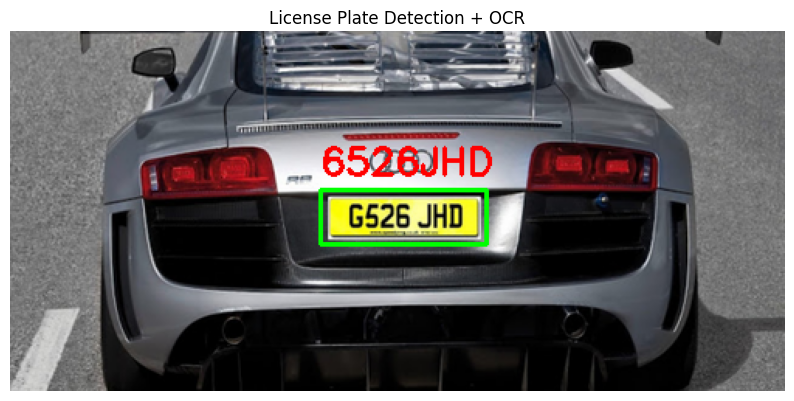

In [ ]:
# model = YOLO("runs/detect/train/weights/best.pt")
# image_path = "D:/Lomhat/ITC/Programming for Data Science/Project/new_pro2/dataset/car_license_plate/test/images/Cars8.png"

# # Load OCR
# reader = easyocr.Reader(['en'])

# # Read and predict
# image = cv2.imread(image_path)
# image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# results = model.predict(image_rgb)

# # Loop over detections
# for result in results:
#     for box in result.boxes:
#         x1, y1, x2, y2 = map(int, box.xyxy[0])
#         cropped = image_rgb[y1:y2, x1:x2]
#         cropped = cv2.resize(cropped, (300, 100))

#         gray = cv2.cvtColor(cropped, cv2.COLOR_RGB2GRAY)
#         blurred = cv2.bilateralFilter(gray, 11, 17, 17)
#         clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
#         enhanced = clahe.apply(blurred)

#         ocr_result = reader.readtext(
#             enhanced,
#             detail=0,
#             allowlist="ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789"
#         )

#         plate_text = " ".join(ocr_result).strip()
        
#         if "MH1Z" in plate_text:
#             plate_text = plate_text.replace("Z", "2")

#         # Draw box + label
#         cv2.rectangle(image_rgb, (x1, y1), (x2, y2), (0, 255, 0), 2)
#         cv2.putText(image_rgb, plate_text, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX,
#                     0.8, (255, 0, 0), 2)

#         print(f"🔤 Detected Plate: {plate_text}")

# # Show result
# plt.figure(figsize=(10, 6))
# plt.imshow(image_rgb)
# plt.axis("off")
# plt.title("License Plate Detection + OCR")
# plt.show()


0: 384x640 1 license_plate, 60.0ms
Speed: 1.8ms preprocess, 60.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)
🔤 Detected Plate: 4012927


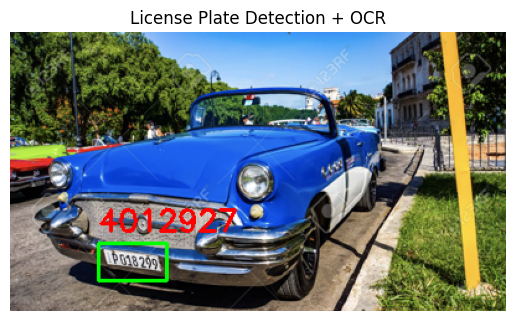

In [5]:
model = YOLO("runs/detect/train/weights/best.pt")
image_path = "D:/Lomhat/ITC/Programming for Data Science/Project/Carplate_Detection_Project/Project From Process/dataset/car_license_plate/test/images/Cars270.png"

# Load OCR
reader = easyocr.Reader(['en'])

# Read and predict
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

results = model.predict(image_rgb)

# Loop over detections
for result in results:
    for box in result.boxes:
        x1, y1, x2, y2 = map(int, box.xyxy[0])
        cropped = image_rgb[y1:y2, x1:x2]
        cropped = cv2.resize(cropped, (300, 100))

        gray = cv2.cvtColor(cropped, cv2.COLOR_RGB2GRAY)
        blurred = cv2.bilateralFilter(gray, 11, 17, 17)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        enhanced = clahe.apply(blurred)

        ocr_result = reader.readtext(
            enhanced,
            detail=0,
            allowlist="ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789"
        )

        plate_text = " ".join(ocr_result).strip()
        
        if "MH1Z" in plate_text:
            plate_text = plate_text.replace("Z", "2")

        # Draw box + label
        cv2.rectangle(image_rgb, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(image_rgb, plate_text, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX,
                    0.8, (255, 0, 0), 2)

        print(f"🔤 Detected Plate: {plate_text}")

# Show result
plt.imshow(image_rgb)
plt.axis("off")
plt.title("License Plate Detection + OCR")
plt.show()